In [1]:
!pip install -U tensorflow-addons

In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import cv2
import seaborn as sns
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

# Plotting settings
sns.set()
plt.rc('font', family = 'serif')

In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (100, 100, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 1000

# AUGMENTATION
IMAGE_SIZE = 100  # We will resize input images to this size.
PATCH_SIZE = IMAGE_SIZE // 8 # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

MODEL_NAME = f"MAE_E{EPOCHS}_MP{MASK_PROPORTION}"

In [4]:
def get_binary_testset(dataset_name):
    """
    `DariusAf_Deepfake_Database` (train_test)
    `Celeb-avg-30-(train/test)`
    `Celeb-rnd-30-(train/test)`
    `Celeb-diff-30-(train/test)`
    """
    testset = None
    path_2_root = "../.."
    if dataset_name == "DariusAf_Deepfake_Database":
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
    elif dataset_name == "Celeb-avg-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
    elif dataset_name == "Celeb-rnd-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
    elif dataset_name == "Celeb-diff-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

    elif dataset_name == "Celeb-avg-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
    elif dataset_name == "Celeb-rnd-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
    elif dataset_name == "Celeb-diff-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"

    elif dataset_name == "DariusAf-OC": # unary
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/"
    elif dataset_name == "DariusAf-OC-test": # binary
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/"

    elif dataset_name == "Celeb-DF-v2-OC": # unary
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/"
    elif dataset_name == "Celeb-DF-v2-OC-val": # unary, only has real class
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"
    elif dataset_name == "Celeb-DF-v2-OC-test": # unary
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/"
    return testset

In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model

In [6]:
def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed


In [8]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [9]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


In [11]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [12]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


In [13]:
class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_images = next(iter(VAL_GEN.next()))
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            plt.axis("off")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")
            plt.axis("off")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")
            plt.axis("off")
            
            plt.show()
            plt.close()


In [14]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    # Some code is taken from:
    # https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [15]:
def load_best_model(model):
    PATH_2_MAP_WEIGHTS_DIR = "../../_WEIGHTS/mae/"
    if os.listdir(PATH_2_MAP_WEIGHTS_DIR):
        model.load_weights(f"{PATH_2_MAP_WEIGHTS_DIR}/weights")

PATH_2_MAP_WEIGHTS_DIR = "../../_WEIGHTS/mae/"

In [16]:
DATASET = get_binary_testset("Celeb-rnd-30-train")
VAL_DATASET = get_binary_testset("Celeb-rnd-30-test") # NOT AN ACTUAL VAL SET
TEST_DATASET = get_binary_testset("Celeb-rnd-30-test")
IMG_DATAGEN = ImageDataGenerator(validation_split=0.2)

GEN = IMG_DATAGEN.flow_from_directory(DATASET,
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      batch_size=BATCH_SIZE,
                                      seed=SEED,
                                      subset="training")

VAL_GEN = IMG_DATAGEN.flow_from_directory(VAL_DATASET,
                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                          batch_size=BATCH_SIZE,
                                          seed=SEED,
                                          subset="validation")

TEST_GEN = IMG_DATAGEN.flow_from_directory(TEST_DATASET,
                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                          batch_size=BATCH_SIZE,
                                          seed=SEED,
                                          class_mode="binary")

Found 44393 images belonging to 2 classes.
Found 3927 images belonging to 2 classes.
Found 19638 images belonging to 2 classes.


Index selected: 17.


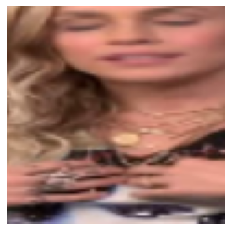

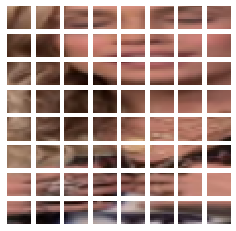

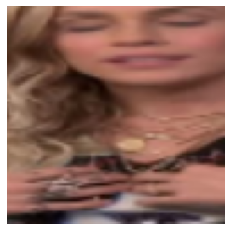

In [17]:
# Get a batch of images.
image_batch = next(iter(GEN.next()))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

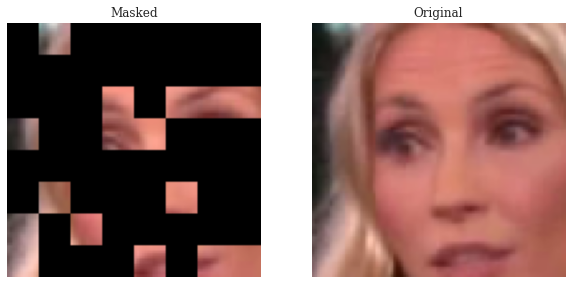

In [18]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [19]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [20]:
# len_x_train = GEN.n
# total_steps = int((len_x_train / BATCH_SIZE) * EPOCHS)
# warmup_epoch_percentage = 0.15
# warmup_steps = int(total_steps * warmup_epoch_percentage)
# scheduled_lrs = WarmUpCosine(learning_rate_base=LEARNING_RATE,
#                              total_steps=total_steps,
#                              warmup_learning_rate=0.0,
#                              warmup_steps=warmup_steps)

# lrs = [scheduled_lrs(step) for step in range(total_steps)]
# plt.plot(lrs)
# plt.xlabel("Step", fontsize=14)
# plt.ylabel("LR", fontsize=14)
# plt.show()

# Assemble the callbacks.
checkpoint = ModelCheckpoint(f"../../_WEIGHTS/mae/weights_{MODEL_NAME}", 
                            save_best_only=True,
                            save_weights_only=True, 
                            monitor='val_loss', 
                            mode='min')
early_stopping = EarlyStopping(patience=50, 
                               restore_best_weights=True, 
                               verbose=1, 
                               monitor='val_loss', 
                               mode='min')
train_monitor = TrainMonitor(epoch_interval=5)                     
train_callbacks = [train_monitor, early_stopping, checkpoint]

In [21]:
scheduled_lrs = LEARNING_RATE
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

# load_best_model(mae_model)

1/1 [==============================] - ETA: 0s - loss: 0.0698 - mae: 0.2170
Idx chosen: 16


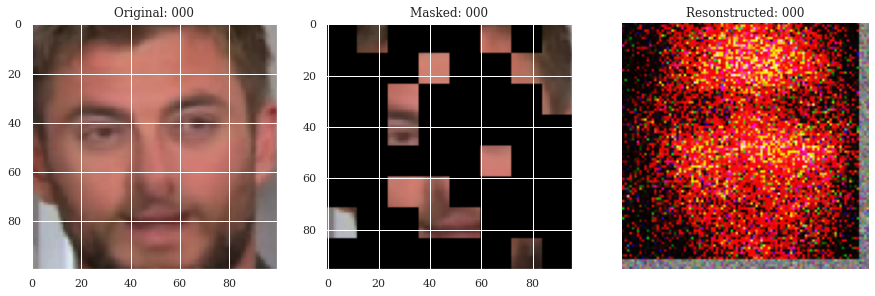

1/1 [==============================] - 19s 19s/step - loss: 0.0698 - mae: 0.2170 - val_loss: 0.1283 - val_mae: 0.3053


In [22]:
# Just fit on a single bacth, Tensorflow is bad
# X, y = GEN.next()
# X = X.astype(np.uint8)
train_ds = tf.data.Dataset.from_tensor_slices(GEN.next()[0].astype(np.uint8))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

# X_v, y_v = VAL_GEN.next()
val_ds = tf.data.Dataset.from_tensor_slices(VAL_GEN.next()[0].astype(np.uint8))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)
history = mae_model.fit(
    train_ds, epochs=1, validation_data=train_ds, callbacks=train_callbacks,
)

Epoch 1/1000
694/694 [==============================] - ETA: 0s - loss: 0.1628 - mae: 0.3555WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs=(<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>). Consider rewriting this model with the Functional API.

Idx chosen: 5


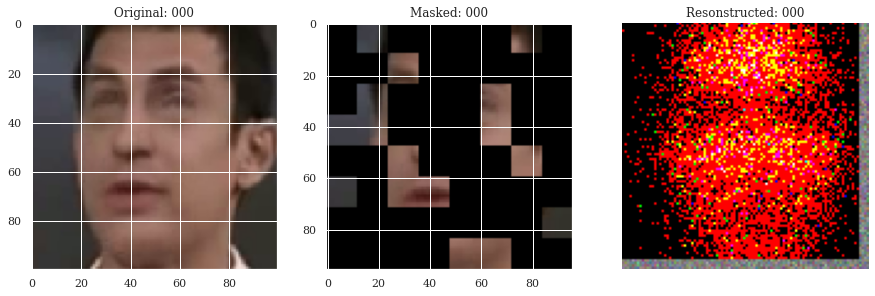

694/694 [==============================] - 696s 997ms/step - loss: 0.1628 - mae: 0.3555 - val_loss: 0.1680 - val_mae: 0.3536
Epoch 2/1000
694/694 [==============================] - 51s 74ms/step - loss: 0.1702 - mae: 0.3647 - val_loss: 0.1707 - val_mae: 0.3563
Epoch 3/1000
694/694 [==============================] - 53s 77ms/step - loss: 0.1726 - mae: 0.3671 - val_loss: 0.1738 - val_mae: 0.3594
Epoch 4/1000
694/694 [==============================] - 63s 91ms/step - loss: 0.1187 - mae: 0.2782 - val_loss: 0.0338 - val_mae: 0.1442
Epoch 5/1000
694/694 [==============================] - 64s 93ms/step - loss: 0.0283 - mae: 0.1293 - val_loss: 0.0334 - val_mae: 0.1428
Epoch 6/1000
694/694 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.1262
Idx chosen: 45


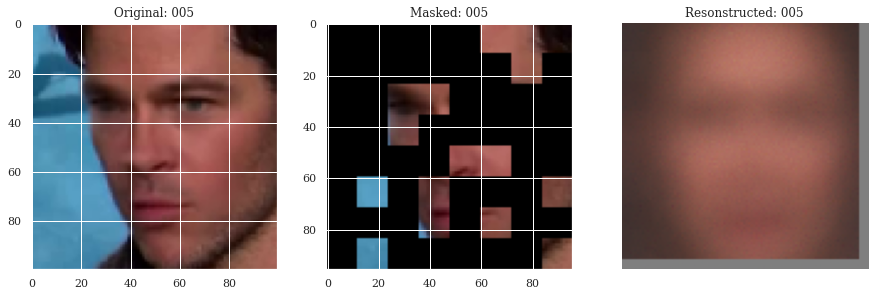

694/694 [==============================] - 69s 99ms/step - loss: 0.0269 - mae: 0.1262 - val_loss: 0.0267 - val_mae: 0.1264
Epoch 7/1000
694/694 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.1079

KeyboardInterrupt: 

In [23]:
# Fit
patch_encoder.downstream = False
history = mae_model.fit(GEN,
                        validation_data=VAL_GEN, 
                        callbacks=train_callbacks,
                        epochs=EPOCHS,
                        verbose=1)

In [ ]:
# Test the model after training
# test_results = model.evaluate(t_X_test, t_y_test, steps=1, verbose=False)
# print(f'Test results - Loss: {test_results[0]:3f} - mse: {100*test_results[1]:.3f}')

plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])
    # plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Masked Autoencoder Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'mae'], loc='center right')
plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Masked Autoencoder Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_mae'], loc='upper right')
plt.show()

In [ ]:
# load_best_model(mae_model)

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="sigmoid"),
    ],
    name="linear_probe_model",
)
# # Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name=f"linear_probe_model_{MODEL_NAME}",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

In [ ]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

In [ ]:
# train_ds = prepare_data(x_train, y_train)
# val_ds = prepare_data(x_train, y_train, is_train=False)
# test_ds = prepare_data(x_test, y_test, is_train=False)

In [ ]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["auc"]
)
downstream_model.fit(GEN, validation_data=val_ds, epochs=linear_probe_epochs)

loss, auc = downstream_model.evaluate(TEST_GEN)
auc = round(auc * 100, 2)
print(f"auc on the test set: {auc}.")

In [ ]:
# score = {0:[],1:[]}
# for b, (X, y) in tqdm(enumerate(TEST_GEN), total=len(TEST_GEN)-1):
#     Z = downstream_model.predict(X)
#     X_prime = decoder.predict(Z)
#     for i in range(y.shape[0]):
#         label = int(y[i])
#         xi = X[i,:].flatten()
#         xo = X_prime[i,:].flatten()
#         recon_loss = (((xi - xo)**2).sum()/TEST_GEN.n)**0.5
#         score[label].append(recon_loss)

#     if b >= (TEST_GEN.samples / TEST_GEN.batch_size) - 1:
#         break

#     if not b % 64:
#         min_r, max_r = int(min(min(score[0]), min(score[1]))), int(max(max(score[0]), max(score[1])))
#         k = 4
#         bins = [x*k for x in range(min_r//k -k//4, max_r//k +k//4)]
#         plt.hist(score[0], bins, alpha=0.7)[2]
#         plt.hist(score[1], bins, alpha=0.7)[2]
#         plt.show()

In [ ]:
# def solve(m1,m2,std1,std2):
#   a = 1/(2*std1**2) - 1/(2*std2**2)
#   b = m2/(std2**2) - m1/(std1**2)
#   c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
#   return np.roots([a,b,c])

# intersec = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))

In [ ]:
# min_r, max_r = int(min(min(score[0]), min(score[1]))), int(max(max(score[0]), max(score[1])))
# k = 4
# bins = [x*k for x in range(min_r//k -k//4, max_r//k +k//4)]
# plt.hist(score[0], bins, alpha=0.7)[2]
# plt.hist(score[1], bins, alpha=0.7)[2]